# **6장. 합성곱 신경망 2**

In [1]:
pip install --user tqdm

# 6.1 이미지 분류를 위한 합성곱 신경망

유형:

**6.1.1 LeNet-5**

합성곱과 다운 샘플링(=풀링)을 반복적으로 거치며, 마지막에 완전연결층에서 분류를 수행하는 것

In [14]:
#1. 필요한 라이브러리 호출

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms #이미지 변환(전처리) 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim #경사하강법 이용하여 가중치 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os #파일 경로에 대한 함수 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm #진행상황(ex: 모델 학습 경과)을 가시적으로 표현해주는 라이브러리
import random
from matplotlib import pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
#2. 이미지 데이터세트 전처리

class ImageTransform() :
  def __init__(self, resize, mean, std) :
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)), #입력이미지를 주어진 크기로 조정(기본 224x224) / 원래 이미지를 무작위 크기(50~100%)만큼 면적 자름
            transforms.RandomHorizontalFlip(), #일정 확률(기본 50%)로 이미지 수평 반전
            transforms.ToTensor(), #효율적인 연산 위해 텐서로 변환
            transforms.Normalize(mean, std) #각 채널별 평균(mean)과 표준편차(std) 정규화
                                      ]),
        'val' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase) : #__call__함수: 클래스 객체 자체를 호출하면 해당 함수의 리턴값 반환
    return self.data_transform[phase](img)

In [11]:
from posixpath import supports_unicode_filenames
#이미지 데이터세트 훈련, 검증, 테스트 세트로 분리

cat_directory = r'/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted( [os.path.join(cat_directory, f) for f in os.listdir(cat_directory)] )
#sorted: 데이터를정렬된 리스트로 만들어서 반환 / os.path.join: 경로와 파일명 결합,또는 분할된 경로 하나로 합칭
# os.listdir: 해당 디렉토리 내 모든 파일 리스트 반환(이미지파일 모두 반환)
dog_images_filepaths = sorted( [os.path.join(dog_directory, f) for f in os.listdir(dog_directory)] )
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths] #개와 고양이 이미지 합쳐서 images_filepaths에 저장
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]

print( len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [16]:
#테스트 데이터셋에 어떤 데이터들이 있는지 확인하는 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
  for i, image_filepath in enumerate(images_filepaths) :
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #입력 이미지 / 변환할 이미지 색상 지정(BlueGreenRed -> RGB컬러)
    true_label = os.path.normpath(image_filepath).split(os.sep)[-2] #경로명 정규화  /  '/'나 '\'기준 분할   /   뒤에서 2번쨰
    predicted_label = predicted_labels[i] if predicted_labels else true_label
    color = 'green' if true_label == predicted_label else 'red'
    ax.ravel()[i].imshow(image) #개별 이미지 출력
    ax.ravel()[i].set_title(predicted_label, color=color)
    ax.ravel()[i].set_axis_off()
  plt.tight_layout()
  plt.show()

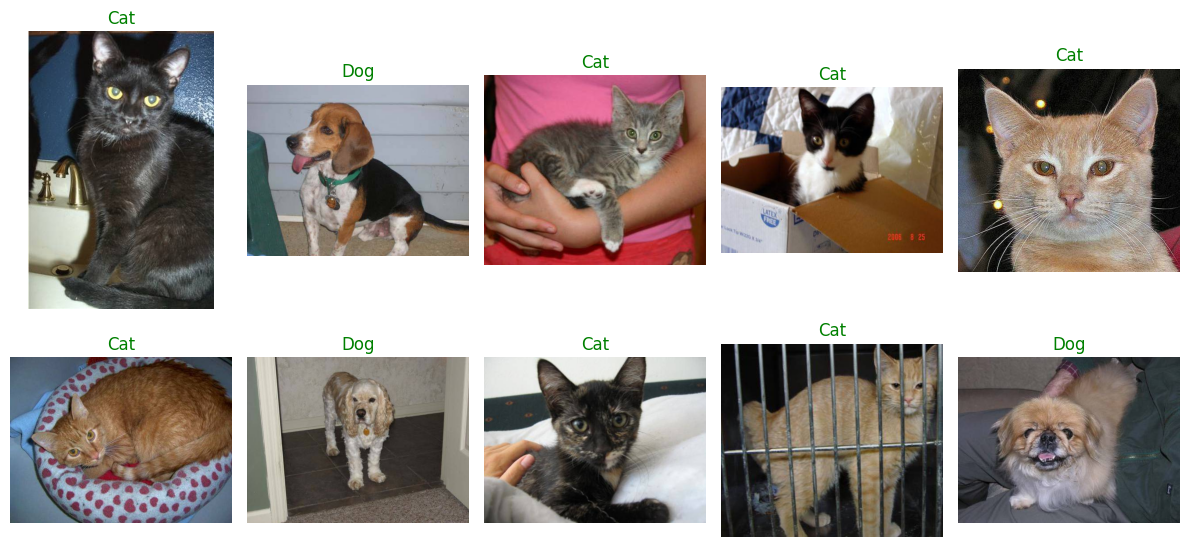

In [17]:
#테스트 데이터세트 이미지 출력
display_image_grid(test_images_filepaths)

In [19]:
#이미지 데이터세트 클래스 정의
class DogVsCatDataset(Dataset) :
  def __init__(self, file_list, transform=None, phase='train') : #데이터셋 전처리하여 적용
    self.file_list = file_list #데이터 경로 저장
    self.transform = transform
    self.phase = phase

  def __len__(self) :
    return len(self.file_list) #images_filepaths 데이터셋 전체 길이 반환

  def __getitem__(self, idx) :
    img_path = self.file_list[idx] #해당 인덱스 이미지의 경로
    img = Image.open(img_path) #경로에서 이미지 데이터 가져옴
    img_transformed = self.transform(img, self.phase) #이미지 'train' 전처리
    label = img_path.split('/')[-1].split('.')[0] #이미지 데이터 경로에 있는 레이블('dog', 'cat') 가져옴
    if label == 'dog' :
      label = 1
    elif label == 'cat' :
      label = 0
    return img_transformed, label

In [20]:
#전처리에 사용할 변수 값 정의
size = 244
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [25]:
#훈련세트, 검증세트 정의

train_dataset = DogVsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogVsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
#torch.Size([3, 244, 244]) >> 이미지가 '컬러' 상태에서 224x224 크기를 가짐
print(train_dataset.__getitem__(index)[1])
#0 또는 1 >> 고양이 또는 개

torch.Size([3, 244, 244])
0


In [26]:
#데이터 로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #데이터를 배치 단위로 쪼개어, 랜덤으로 불러옴
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = { 'train':train_dataloader, 'val':val_dataloader }

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 244, 244])
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 0])
